In [1]:
import os, shutil, glob
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # if we have only one GPU, otherwise "0, 1, etc"
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15656771760623565833
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15136549986226320836
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15384736566674085661
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10943175066
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6175536302814730229
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1"
]


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
from PIL import Image
import random
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc, roc_auc_score

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# TensorFlow and Keras
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.regularizers import l2
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import utils 

# import keras
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from tensorflow.keras import optimizers 

print(tf.__version__)

#scratch-shared/maris/tests/labels.csv
#scratch-shared/maris/tests/MiCoPh_Image_0_255
#scratch-shared/maris/tests/MiSyHo_Image_0_255

2.1.0


## Load the images

In [3]:
basedir1 = input("Enter first directory name of images: ") # e.g. /home/jovyan/scratch-shared/maris/tests/MiCoPh_Image_0_255 

Enter first directory name of images:  /home/jovyan/scratch-shared/maris/tests/MiCoPh_Image_0_255


In [4]:
print(len(os.listdir(basedir1)))

12301


In [5]:
basedir2 = input("Enter second directory name of images: ") # e.g. /home/jovyan/scratch-shared/maris/tests/MiSyHo_Image_0_255

Enter second directory name of images:  /home/jovyan/scratch-shared/maris/tests/MiSyHo_Image_0_255


In [6]:
print(len(os.listdir(basedir2)))

12301


## Preprocessing

In [7]:
df=pd.read_csv('/home/jovyan/scratch-shared/maris/tests/labels.csv', sep=';')
df.columns = ['nr','plate','well',
                     'site','type','compoundname','target','concentration']
df.fillna("NotKnown", inplace = True)

df["target"] = df["target"].str.replace(' ', '') #remove spaces
df["target"] = df["target"].str.replace('c-Kit', 'cKit') #
df["target"] = df["target"].str.replace('GSK-3', 'GSK3') #
df["target"] = df["target"].str.replace('VEGFR', 'VEGrFR') #so that string EGFR is not in VEGFR
df['target'] = np.where((df['type'] == 'control'), df['type'] , df['target'])

df["filename"] = df["nr"].astype(str) + ".png"

df

,nr,plate,well,site,type,compoundname,target,concentration,filename
0,0,P009063,B02,1,compound,CBK013405,EGFR,10,0.png
1,1,P009063,B02,2,compound,CBK013405,EGFR,10,1.png
2,2,P009063,B02,3,compound,CBK013405,EGFR,10,2.png
3,3,P009063,B02,4,compound,CBK013405,EGFR,10,3.png
4,4,P009063,B02,5,compound,CBK013405,EGFR,10,4.png
...,...,...,...,...,...,...,...,...,...
12295,12295,P009083,G11,5,compound,CBK293913C,Rho,4,12295.png
12296,12296,P009083,G11,6,compound,CBK293913C,Rho,4,12296.png
12297,12297,P009083,G11,7,compound,CBK293913C,Rho,4,12297.png
12298,12298,P009083,G11,8,compound,CBK293913C,Rho,4,12298.png


In [8]:
activities = sorted(list(set(df['target']))) 
for a in activities:
    if ',' in a:
        
        df[a] = [1 if a == x else 0 for x in df['target']]
    else:
        df[a] = [1 if a in x else 0 for x in df['target']] # COMPOUNDS THAT HAVE SEVERAL TARGETS GET VALUE 1 FOR EACH TARGET
print(activities)

['ALK', 'AMPK', 'ATM', 'ATM/ATR', 'Akt', 'Akt,CDK,PKA', 'Akt,MEK', 'Akt,PDK-1', 'Akt,S6kinase', 'AuroraKinase', 'AuroraKinase,FGFR,Bcr-Abl,c-RET,Src', 'AuroraKinase,VEGrFR', 'BTK', 'Bcr-Abl', 'Bcr-Abl,JAK,AuroraKinase', 'Bcr-Abl,VEGrFR,FGFR,PDGFR,Flt', 'CDK', 'CDK,AuroraKinase', 'CHK', 'Chk', 'DNA-PK,PI3K', 'DNA-PK,PI3K,mTOR', 'DNA-PK,mTOR,PDGF', 'DUB,Bcr-Abl', 'EGFR', 'EGFR,Flt,VEGrFR,HER2', 'EGFR,HER2', 'EGFR,mTOR', 'ERK', 'FAK', 'FGFR', 'FGFR,VEGrFR', 'FLT3', 'Flt', 'Flt,AuroraKinase,VEGrFR', 'Flt,Bcr-Abl,AuroraKinase', 'Flt,FGFR,PDGFR,VEGrFR,cKit', 'Flt,JAK,c-RET', 'FreeBase', 'GSK3', 'HDAC,EGFR,HER2', 'HDAC,PI3K', 'HER2', 'HER2,EGFR', 'IA/ASB/IKK', 'IGF-1,ALK', 'IGF-1R', 'IKK', 'I¦ÊB/IKK', 'JAK', 'JAK,EGFR', 'JNK', 'LRRK2', 'MEK', 'NotKnown', 'Others', 'PAK', 'PDGFR', 'PDGFR,VEGrFR', 'PDGFR,cKit,Bcr-Abl', 'PDK-1', 'PDK-1,IKK', 'PI3K', 'PI3K,DNA-PK', 'PI3K,PKC,Src,Sirtuin', 'PI3K,VEGrFR', 'PI3K,mTOR', 'PI3K/Akt/mTOR', 'PKC', 'PLK', 'Pim', 'ProductCategoriesPI3K/Akt/mTORPI3KPI3K', '

In [9]:
nrclasses = len(activities)
nrclasses

115

In [10]:
df = df[df.NotKnown != 1]
df = df.drop(columns='NotKnown')
activities.remove('NotKnown')
df

,nr,plate,well,site,type,compoundname,target,concentration,filename,ALK,...,c-Myc,"cKit,FGFR,Flt,VEGrFR,PDGFR","cKit,PDGFR,FGFR,FAK","cKit,Raf,VEGrFR","cKit,VEGrFR",control,mTOR,"mTOR,PI3K","mTOR,PI3K,Akt",p38MAPK
0,0,P009063,B02,1,compound,CBK013405,EGFR,10,0.png,0,...,0,0,0,0,0,0,0,0,0,0
1,1,P009063,B02,2,compound,CBK013405,EGFR,10,1.png,0,...,0,0,0,0,0,0,0,0,0,0
2,2,P009063,B02,3,compound,CBK013405,EGFR,10,2.png,0,...,0,0,0,0,0,0,0,0,0,0
3,3,P009063,B02,4,compound,CBK013405,EGFR,10,3.png,0,...,0,0,0,0,0,0,0,0,0,0
4,4,P009063,B02,5,compound,CBK013405,EGFR,10,4.png,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12295,12295,P009083,G11,5,compound,CBK293913C,Rho,4,12295.png,0,...,0,0,0,0,0,0,0,0,0,0
12296,12296,P009083,G11,6,compound,CBK293913C,Rho,4,12296.png,0,...,0,0,0,0,0,0,0,0,0,0
12297,12297,P009083,G11,7,compound,CBK293913C,Rho,4,12297.png,0,...,0,0,0,0,0,0,0,0,0,0
12298,12298,P009083,G11,8,compound,CBK293913C,Rho,4,12298.png,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
nrclasses = len(activities)
nrclasses

114

In [12]:
df['plate_well'] = df['plate'] + df['well']
welllist = sorted(list(set(df['plate_well'])))
print(len(welllist))
print(welllist[0:5])

def partitions (list_in, n):
    random.seed(1)
    random.shuffle(list_in)
    return [list_in[i::n] for i in range(n)]

chunks = partitions(welllist, 5) #split the dataset in 5 folds excluding 20% of images (a better way to validate would be excluding 20% of wells)
#print (chunks[0])
len(chunks)
df1=df[~df['plate_well'].isin(chunks[0])]
df2=df[df['plate_well'].isin(chunks[0])]
print(len(set(df1['nr'])))
print(len(df2))


1253
['P009063B02', 'P009063B03', 'P009063B04', 'P009063B05', 'P009063B06']
9738
2499


In [13]:
df1=df1.sort_values(by='filename') 
df1=df1.reset_index()

df2=df2.sort_values(by='filename')
df2=df2.reset_index()
df2.head()

,index,nr,plate,well,site,type,compoundname,target,concentration,filename,...,"cKit,FGFR,Flt,VEGrFR,PDGFR","cKit,PDGFR,FGFR,FAK","cKit,Raf,VEGrFR","cKit,VEGrFR",control,mTOR,"mTOR,PI3K","mTOR,PI3K,Akt",p38MAPK,plate_well
0,10014,10014,P009079,F08,1,control,DMSO,control,10,10014.png,...,0,0,0,0,1,0,0,0,0,P009079F08
1,10015,10015,P009079,F08,2,control,DMSO,control,10,10015.png,...,0,0,0,0,1,0,0,0,0,P009079F08
2,10016,10016,P009079,F08,3,control,DMSO,control,10,10016.png,...,0,0,0,0,1,0,0,0,0,P009079F08
3,10017,10017,P009079,F08,4,control,DMSO,control,10,10017.png,...,0,0,0,0,1,0,0,0,0,P009079F08
4,10018,10018,P009079,F08,5,control,DMSO,control,10,10018.png,...,0,0,0,0,1,0,0,0,0,P009079F08


## Calculate class weights

In [14]:
def calculating_class_weights(y_true):
    from sklearn.utils.class_weight import compute_class_weight
    number_dim = np.shape(y_true)[1]
    weights = np.empty([number_dim, 2])
    for i in range(number_dim):
        weights[i] = compute_class_weight('balanced', [0.,1.], y_true[:, i])
    return weights

def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss

def weighted_loss(y_true, y_pred):
    return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)

import tensorflow.keras.losses
keras.losses.weighted_loss = weighted_loss

class_weights = calculating_class_weights(df[activities].values)
print (class_weights)

scaling = 0 # some number between 0 and 1; if 0, no scaling is performed
class_weights_scaled = class_weights**scaling
print (class_weights_scaled) 

[[  0.50557759  45.32222222]
 [  0.50445214  56.65277778]
 [  0.50670807  37.76851852]
 [  0.50445214  56.65277778]
 [  0.51803404  14.36267606]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.52645844   9.94878049]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.50333169  75.53703704]
 [  0.52041337  12.746875  ]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.52523822  10.40561224]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.50445214  56.65277778]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.5402649    6.70888158]
 [  0.50110565 226.61111111]
 [  0.50759084  33.43442623]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.50445214  56.65277778]
 [  0.51476527  17.43162393]
 [  0.50110565 226.61111111]
 [  0.50110565 226.61111111]
 [  0.5171146   15.10740741]
 [  0.50110565

## ImageDataGenerator and FlowFromDataframe

In [15]:
datagen= ImageDataGenerator(rescale=(1./255), horizontal_flip=True, vertical_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255.)

classes = None
#target_size = 270, 270
target_size = 224, 224 #input size for VGG16
x_col = 'filename'
y_col = activities

train_generator1=datagen.flow_from_dataframe(
dataframe=df1,
directory=basedir1,
x_col="filename",
has_ext=True,
y_col=y_col,
batch_size=32,
seed=42,
shuffle=True,
class_mode="other",
classes = classes,
interpolation = "lanczos",
target_size=target_size)

validation_generator1=datagen.flow_from_dataframe(
dataframe=df2,
directory=basedir1,
x_col="filename",
has_ext=True,
y_col=y_col,
batch_size=1,
seed=42,
shuffle=False,
class_mode="other",
classes=classes,
interpolation = "lanczos",
target_size=target_size)

test_generator1=datagen.flow_from_dataframe(
dataframe=df2,
directory=basedir1,
x_col="filename",
has_ext=True,
y_col=y_col,
batch_size=1,
seed=42,
shuffle=False,
class_mode="other",
interpolation = "lanczos",
target_size=target_size)

train_generator2=datagen.flow_from_dataframe(
dataframe=df1,
directory=basedir2,
x_col="filename",
has_ext=True,
y_col=y_col,
batch_size=32,
seed=42,
shuffle=True,
class_mode="other",
classes=classes,
interpolation = "lanczos",
target_size=target_size)

validation_generator2=datagen.flow_from_dataframe(
dataframe=df2,
directory=basedir2,
x_col="filename",
has_ext=True,
y_col=y_col,
batch_size=1,
seed=42,
shuffle=False,
class_mode="other",
classes=classes,
interpolation = "lanczos",
target_size=target_size)

test_generator2=datagen.flow_from_dataframe(
dataframe=df2,
directory=basedir2,
x_col="filename",
has_ext=True,
y_col=y_col,
batch_size=1,
seed=42,
shuffle=False,
class_mode="other",
interpolation = "lanczos",
target_size=target_size)

Found 9738 validated image filenames.
Found 2499 validated image filenames.
Found 2499 validated image filenames.
Found 9738 validated image filenames.
Found 2499 validated image filenames.
Found 2499 validated image filenames.


In [ ]:
''' def doubleGenerator(generator1,generator2): #Input size of (224,224,5)
    while True:
        for (x1,y1),(x2,y2) in zip(generator1,generator2):
            yield (np.concatenate((x1,x2[:,:,:,1:]), axis=3),y1)'''

In [16]:
def doubleGenerator(generator1,generator2): #for 2 networks with 3 channels each
    while True:
        for (x1,y1),(x2,y2) in zip(generator1,generator2):
            yield ([x1,x2],y1)

## VGG16


In [17]:
from tensorflow.keras.applications.vgg16 import VGG16

In [18]:
pre_trained_model1 = VGG16(input_shape=(224,224,3), include_top=False, weights='imagenet')

pre_trained_model2 = VGG16(input_shape=(224,224,3), include_top=False, weights='imagenet')

for i, layer in enumerate(pre_trained_model2.layers):
    layer._name = 'layer_' + str(i)

In [19]:
pre_trained_model1.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [20]:
pre_trained_model2.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_0 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
layer_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
layer_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
layer_3 (MaxPooling2D)       (None, 112, 112, 64)      0         
_________________________________________________________________
layer_4 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
layer_5 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
layer_6 (MaxPooling2D)       (None, 56, 56, 128)       0     

In [42]:
#from tensorflow.keras.optimizers import Adam
#opt = Adam(lr=0.001)
#model1.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
#from tensorflow.keras.optimizers import Adam
#opt = Adam(lr=0.001)
#model2.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [21]:
last_output1 = pre_trained_model1.output
last_output2 = pre_trained_model2.output
print ('Pre-trained network 1: last layer output shape:', last_output1.shape)
print ('Pre-trained network 2: last layer output shape:', last_output2.shape)

Pre-trained network 1: last layer output shape: (None, 7, 7, 512)
Pre-trained network 2: last layer output shape: (None, 7, 7, 512)


In [22]:
for layer in pre_trained_model1.layers:   #True is default. Can be changed to False
  layer.trainable = True
for layer in pre_trained_model2.layers:
  layer.trainable = True

In [23]:
x1 = layers.GlobalAveragePooling2D(name='avg_pool1')(last_output1)
x2 = layers.GlobalAveragePooling2D(name='avg_pool2')(last_output2)

In [24]:
#Concatenate dense layers of the two networks
xmerged = layers.concatenate(axis=-1, inputs=[x1, x2])
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(xmerged)
#x = layers.Dense(512, activation='relu')(xmerged) # is it needed?

# Create output layer with n_classes nodes and sigmoid activation
output = layers.Dense(nrclasses, activation='sigmoid')(x) # ACTIVATION IS SIGMOID

In [24]:
''' # Original VGG16 instead of GlobalAveragePooling2D uses Flatten and also adds two Dense layers. That increases the number of params from 15M to 130M. Can be difficult to run on a single GPU.

x1 = layers.Flatten(name='flatten1')(last_output1)
x2 = layers.Flatten(name='flatten2')(last_output2)
xmerged = layers.concatenate(axis=-1, inputs=[x1, x2])
x = layers.Dense(4000, activation = 'relu')(xmerged)
x = layers.Dropout(0.5)(x)
x = layers.Dense(4000, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)

# Create output layer with n_classes nodes and sigmoid activation
output = layers.Dense(nrclasses, activation='sigmoid')(x) '''

" # Original VGG16 instead of GlobalAveragePooling2D uses Flatten and also adds two Dense layers. That increases the number of params from 15M to 130M. Can be difficult to run on a single GPU.\n\nx1 = layers.Flatten(name='flatten1')(last_output1)\nx2 = layers.Flatten(name='flatten2')(last_output2)\nxmerged = layers.concatenate(axis=-1, inputs=[x1, x2])\nx = layers.Dense(4000, activation = 'relu')(xmerged)\nx = layers.Dropout(0.5)(x)\nx = layers.Dense(4000, activation = 'relu')(x)\nx = layers.Dropout(0.5)(x)\n\n# Create output layer with n_classes nodes and sigmoid activation\noutput = layers.Dense(nrclasses, activation='sigmoid')(x) "

In [25]:
model = models.Model(inputs=[pre_trained_model1.input, pre_trained_model2.input], outputs=[output])

try:
    model = multi_gpu_model(model, gpus=2)
    print ('Using 2 GPUs')
except:
    print ("No more than 1 GPU available")
    

model.compile(optimizers.SGD(lr=0.0001, decay=1e-6), loss='binary_crossentropy', metrics = ['acc']) 
#model.compile(loss=keras.losses.binary_crossentropy,  optimizer=keras.optimizers.Adam(lr=0.0001), metrics=['acc']) # LOSSES ARE BINARY

Instructions for updating:
Use `tf.distribute.MirroredStrategy` instead.
No more than 1 GPU available


In [26]:
#model.summary()


In [27]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('ModelMay12-VGG16-pretrained-SGD-{epoch:02d}-{loss:.4f}-{acc:.4f}-{val_loss:.4f}-{val_acc:.4f}.hdf5',
                               monitor='val_loss', verbose=0,
                                save_best_only=False, save_weights_only=False, mode='auto')

In [28]:
STEP_SIZE_TRAIN=train_generator1.n//train_generator1.batch_size
STEP_SIZE_VALID=validation_generator1.n//validation_generator1.batch_size
STEP_SIZE_TEST=test_generator1.n//test_generator1.batch_size

In [29]:
history = model.fit_generator(generator=doubleGenerator(train_generator1, train_generator2),
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=doubleGenerator(validation_generator1, validation_generator2),
                    validation_steps=STEP_SIZE_VALID,
                    epochs=5,
                    callbacks = [checkpointer]
                    )

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 304 steps, validate for 2499 steps
Epoch 1/5
304/304 [==============================] - 490s 2s/step - loss: 0.7740 - acc: 0.5083 - val_loss: 0.7112 - val_acc: 0.5257
Epoch 2/5
304/304 [==============================] - 431s 1s/step - loss: 0.7396 - acc: 0.5334 - val_loss: 0.6818 - val_acc: 0.5555
Epoch 3/5
304/304 [==============================] - 432s 1s/step - loss: 0.7104 - acc: 0.5576 - val_loss: 0.6541 - val_acc: 0.5964
Epoch 4/5
304/304 [==============================] - 433s 1s/step - loss: 0.6829 - acc: 0.5836 - val_loss: 0.6255 - val_acc: 0.6449
Epoch 5/5
304/304 [==============================] - 434s 1s/step - loss: 0.6537 - acc: 0.6140 - val_loss: 0.5935 - val_acc: 0.6978


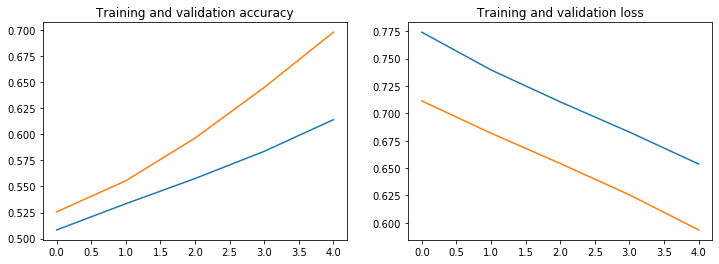

In [30]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

#Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(121)
ax1.plot(epochs, acc)
ax1.plot(epochs, val_acc)
ax1.set_title('Training and validation accuracy')

# Plot training and validation loss per epoch
ax2 = fig.add_subplot(122)
ax2.plot(epochs, loss)
ax2.plot(epochs, val_loss)
ax2.set_title('Training and validation loss')

fig.savefig('loss_VGG16_pretrained_SGD_lr0.0001_batch32.png', dpi=300) # SAVE FIGURE

In [31]:
test_generator1.reset()
test_generator2.reset()
predictions = model.predict_generator(doubleGenerator(test_generator1, test_generator2), verbose=1, steps=test_generator1.samples/test_generator1.batch_size)

Instructions for updating:
Please use Model.predict, which supports generators.
2499/2499 [==============================] - 109s 44ms/step


In [32]:
print(predictions[:,0:5])

[[0.41365266 0.5502696  0.27458817 0.28502288 0.48757008]
 [0.42814285 0.5252122  0.28706816 0.29956245 0.47572547]
 [0.41732866 0.5667304  0.29686078 0.30994347 0.5416449 ]
 ...
 [0.4100153  0.52565277 0.28175008 0.32807642 0.430582  ]
 [0.37368095 0.5265633  0.30173537 0.3088938  0.5226304 ]
 [0.3593563  0.5157804  0.30687964 0.3345077  0.5782862 ]]


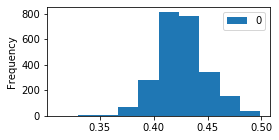

In [33]:
pd.DataFrame(predictions[:,0]).plot(kind='hist', figsize=(4, 2))

In [34]:
y = df2[activities].values
y.shape

(2499, 114)

In [35]:
auc_of_models = pd.DataFrame(columns = ['target/activity', 'roc area'])

for i in range(nrclasses):
    try:
        roc_auc = (roc_auc_score(y[:,i], predictions[:,i]))
        print("roc_auc for class '%s'" % activities[i], roc_auc)
    except:
        continue
        
auc_of_models.to_csv('rocauc_VGG16_pretrained_SGD_lr0.0001_batch32.csv', sep=',') #SAVE ROC_AUC

roc_auc for class 'ALK' 0.28344489067380635
roc_auc for class 'AMPK' 0.4605058132566223
roc_auc for class 'ATM' 0.44045906748172114
roc_auc for class 'ATM/ATR' 0.5076134175287743
roc_auc for class 'Akt' 0.5462951835669587
roc_auc for class 'Akt,PDK-1' 0.26247211066488174
roc_auc for class 'Akt,S6kinase' 0.6943328871039715
roc_auc for class 'AuroraKinase' 0.6040571631953934
roc_auc for class 'AuroraKinase,FGFR,Bcr-Abl,c-RET,Src' 0.38027666220437306
roc_auc for class 'BTK' 0.40015226835057544
roc_auc for class 'Bcr-Abl' 0.2410440415693815
roc_auc for class 'CDK' 0.6313120078302265
roc_auc for class 'CDK,AuroraKinase' 0.9252565818830879
roc_auc for class 'CHK' 0.6821062025881303
roc_auc for class 'Chk' 0.45508210475848015
roc_auc for class 'DNA-PK,PI3K,mTOR' 0.5177153056671129
roc_auc for class 'DUB,Bcr-Abl' 0.5595716198125836
roc_auc for class 'EGFR' 0.4281989194852148
roc_auc for class 'EGFR,HER2' 0.5302792442345096
roc_auc for class 'ERK' 0.2385319053993753
roc_auc for class 'FAK' 0.51

In [36]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nrclasses):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [37]:
print(roc_auc["micro"])

0.5520638631509208


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  if __name__ == '__main__':


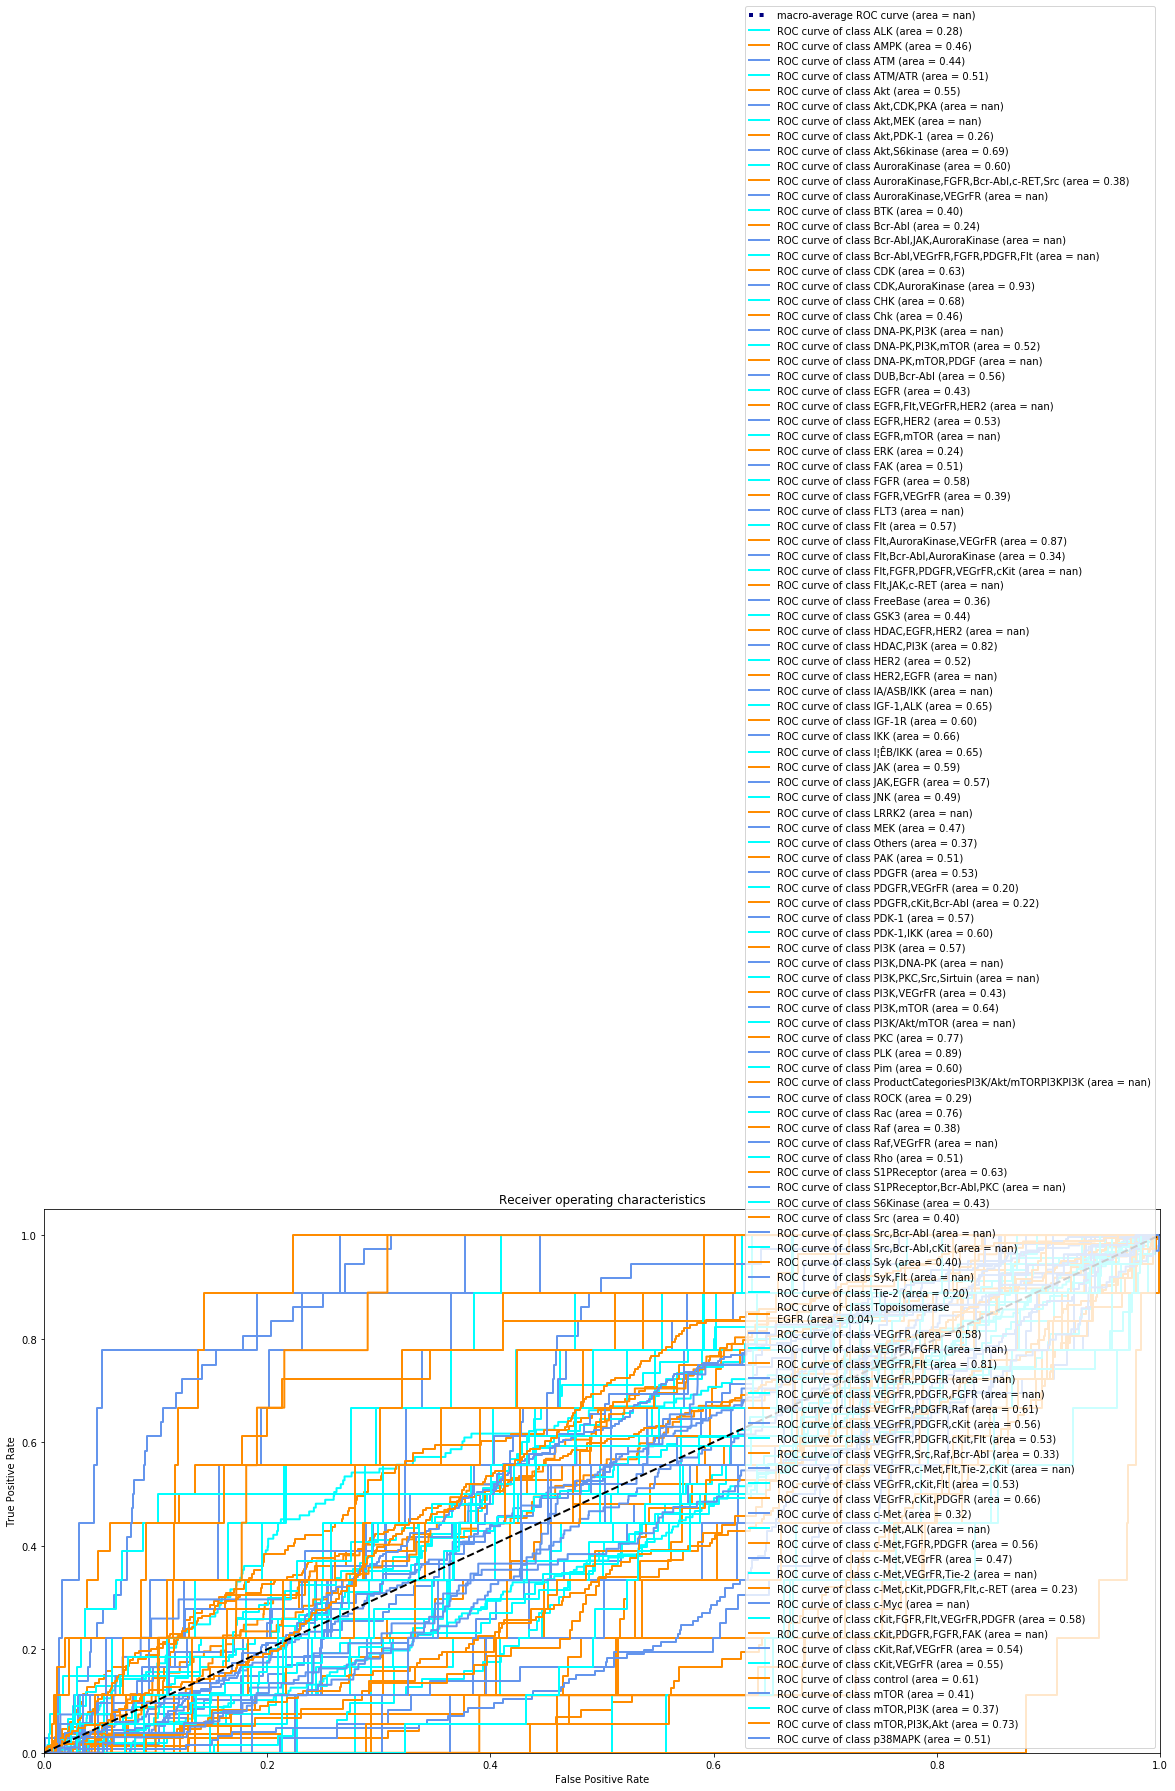

<Figure size 1440x720 with 0 Axes>

In [38]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nrclasses)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(nrclasses):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= nrclasses

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.rcParams["figure.figsize"] = (20,10)
plt.figure()
# plt.plot(fpr["micro"], tpr["micro"],
#         label='micro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["micro"]),
#         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(nrclasses), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(activities[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics')
plt.legend(loc="lower right")
plt.show()

plt.savefig('rocauc_VGG16_pretrained_SGD_lr0.0001_batch32.png', dpi=300) # SAVE FIGURE

In [ ]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

#Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(121)
ax1.plot(epochs, acc)
ax1.plot(epochs, val_acc)
ax1.set_title('Training and validation accuracy')

# Plot training and validation loss per epoch
ax2 = fig.add_subplot(122)
ax2.plot(epochs, loss)
ax2.plot(epochs, val_loss)
ax2.set_title('Training and validation loss')


In [ ]:
test_generator1.reset()
test_generator2.reset()
predictions = model.predict_generator(doubleGenerator(test_generator1, test_generator2), verbose=1, steps=test_generator1.samples/test_generator1.batch_size)

In [ ]:
print(predictions[:,0])

In [ ]:
pd.DataFrame(predictions[:,0]).plot(kind='hist', figsize=(4, 2))

In [ ]:
y = df2[activities].values
y.shape

In [ ]:
for i in range(nrclasses):
    roc_auc = (roc_auc_score(y[:,i], predictions[:,i]))
    print("roc_auc for class '%d'" % i, roc_auc)

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nrclasses):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
print (roc_auc["micro"])

In [ ]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nrclasses)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(nrclasses):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= nrclasses

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.rcParams["figure.figsize"] = (20,10)
plt.figure()
# plt.plot(fpr["micro"], tpr["micro"],
#         label='micro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["micro"]),
#         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(nrclasses), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('Model-18-0.0379-0.9856-0.4761-0.9134.hdf5')

In [ ]:
dir(pre_trained_model2.input)

In [ ]:
print(tf.__version__)
print(keras.__version__)


In [ ]:
from keras.layers import Dense
import keras
from keras.models import  Model
model1 = keras.applications.vgg16.VGG16(include_top=True, weights='imagenet',
                                input_tensor=None, input_shape=None,
                                pooling=None,
                                classes=1000)
model1.layers.pop()

model2 =  keras.applications.vgg16.VGG16(include_top=True, weights='imagenet',
                                input_tensor=None, input_shape=None,
                                pooling=None,
                                classes=1000)
model2.layers.pop()
for layer in model2.layers:
    layer.name = layer.name + str("two")
model1.summary()
model2.summary()
featureLayer1 = model1.output
featureLayer2 = model2.output
combineFeatureLayer = keras.layers.concatenate([featureLayer1, featureLayer2])
prediction = Dense(1, activation='sigmoid', name='main_output')(combineFeatureLayer)

model = Model(inputs=[model1.input, model2.input], outputs= prediction)
model.summary()

In [ ]:
pre_trained_model1.input

In [24]:
dir(tensorflow.keras.layers)

NameError: name 'tensorflow' is not defined